# Generating Description of Images with Deep Neural Networks

## Project Description:

In this project, a deep learning model is trained to generate a description of the image. The relevant code and details of the train/test data, model architecture are summarized in this Jupyter notebook.

The model architecture is as in the following diagram.

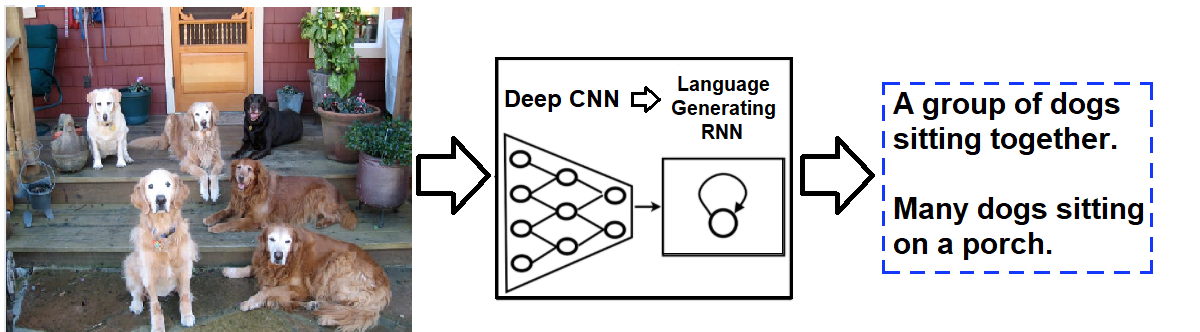

# Importing Required Libraries

Import from libraries shared in GitHub Repository i.e. download_utils.py, tqdm_utils.py, utils.py, keras_utils.py

NOTE: This project has been built using Tensorflow 1.x

In [ ]:
import download_utils
"""
if bool(int(os.environ.get("EXPERIMENTAL_TQDM", "0"))):
    os.system("pip install --force https://github.com/hse-aml/intro-to-dl/releases/download/ColabTqdm/tqdm-colab.zip")
else:
    os.system("pip install tqdm")
os.system("pip install --upgrade Keras==2.0.6") 
"""
download_utils.download_resources("../readonly") # download and save required data files

def setup_keras():
    import download_utils
    download_utils.download_all_keras_resources("../readonly/keras/models", "../readonly/keras/datasets")

setup_keras()

In [2]:
import sys
sys.path.append("..")

In [0]:
download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Download required data for building the model

It takes 10 hours to download relevant data (varies according to internet speed).The total size of the data assets is approximately ~ 20 GB.

Relevant links:
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# resources are already downloaded, they are linked here
download_utils.link_resources()

# Extracting image features

Utilizing the pre-trained version of InceptionV3 model for the CNN encoder.

For more information, refer to this article:
https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html 

The last hidden layer is extracted as embedding. The model architecture is shown as in the following diagram.

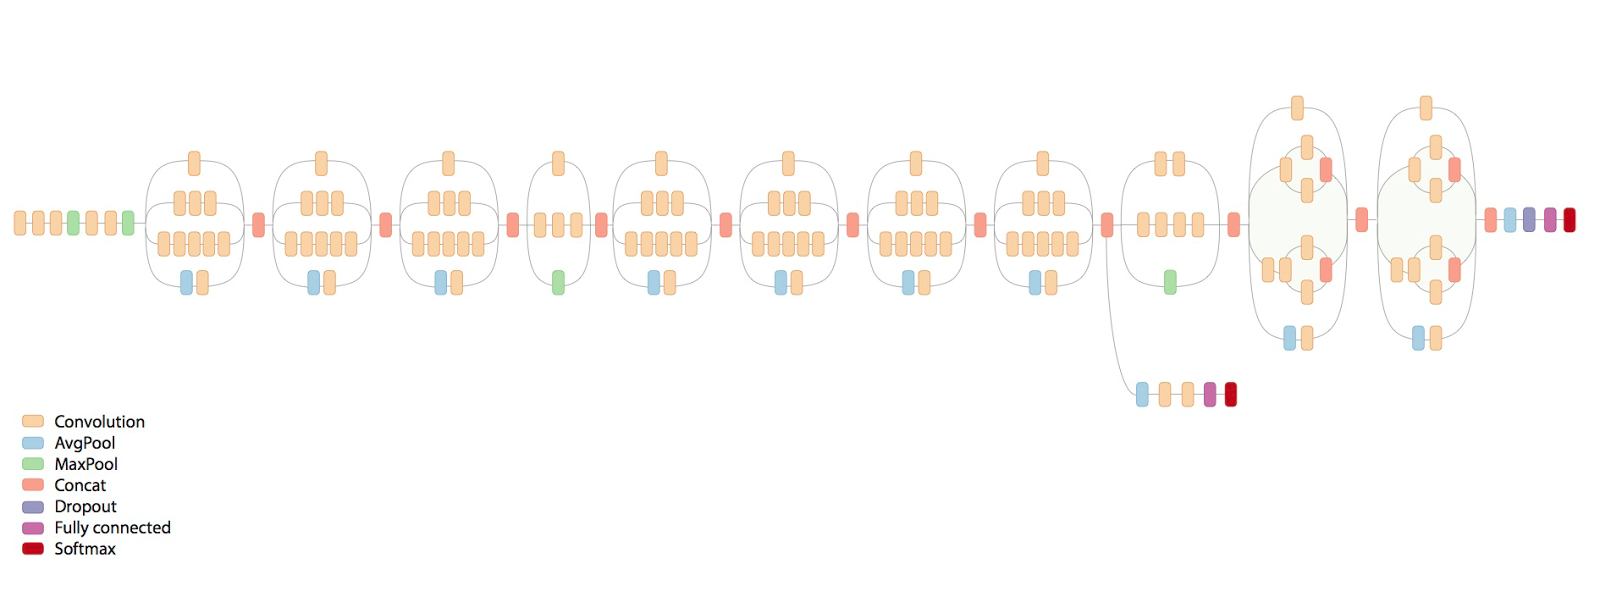

In [0]:
IMG_SIZE = 299 # setting the image size

In [1]:
# The last hidden layer of IncetionV3 is acquired for use as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU, but takes a little more than 16 minutes on GPU.

Extraction is already done with the following code:
```python
# loading pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extracting train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extracting validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [13]:
# loading prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# checking shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [14]:
# checking prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extracting captions for images

In [15]:
# Caption/Image descriptions extracted form zip file.
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# checking shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


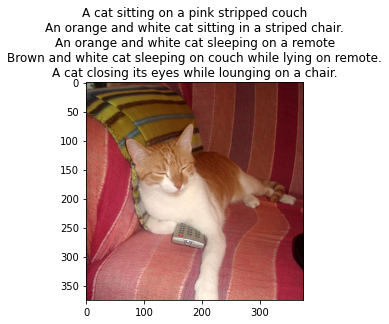

In [16]:
# Checking a training sample's caption/description (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    Change example_idx to see different images and their corresponding captions
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=150)

# Preparing captions for training

In [17]:
# Checking the preview of captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
from collections import Counter
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# splitting sentences into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` - from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Using `split_sentence` function to split sentence into tokens.
    Also, adding PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    words = [sentence for captions in train_captions for sentence in captions]
    words = split_sentence(' '.join(words))
    
    count = Counter(words)
    vocab = [token for token, count in count.items() if count >= 5]
    
    vocab.extend([PAD, UNK, START, END]) 
    return {token: index for index, token in enumerate(sorted(vocab))}

    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Using `split_sentence` function to split sentence into tokens.
    Replacing all tokens with vocabulary indices, using UNK for unknown words (out of vocabulary).
    Adding START and END tokens to start and end of each sentence respectively.
    For the above 'captions' argument, the following is the output:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions]
    return res

In [19]:
# preparing vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
# replacing tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, so in order to batch them PAD tokens are added to keep all caption sentence of equal length. 

LSTM is used to crunch through all the tokens, and PAD token will be ignored during loss calculation - as they do not contain any valuable information regarding the image.

In [0]:
# This function definition is used during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Placing vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
        
    Adding padding with pad_idx where necessary. For instance,
    
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    
    numpy is used in order make this function execution faster.
    """
    if max_len is None:
        max_len = max(map(len, batch_captions))
    else:
        max_len = min(max_len, max(map(len, batch_captions)))
    
    matrix = [[index for i, index in enumerate(caption[:max_len])] + [pad_idx]*(max(max_len-len(caption),0)) for caption in batch_captions]
    return np.array(matrix)

In [0]:
# Confirming that the correct argument is used in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training the Model

## Defining the Model architecture

The objective is to generate image captions, so the RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

NOTE: the image feature vector is transformed to RNN hidden state size by fully-connected layer and then passed to RNN.

During training ground truth tokens is passed to the LSTM to get prediction of next tokens. 


In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# reset the computational graph in order to build the model from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

The computation graph for the decoder is defined here.

Keras layers are used in a functional style with weights, which are reused as follows:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # apply Dense Layer
dense_layer(b)  # apply Dense Layer
```

Flattening in decoder occurs as follows:

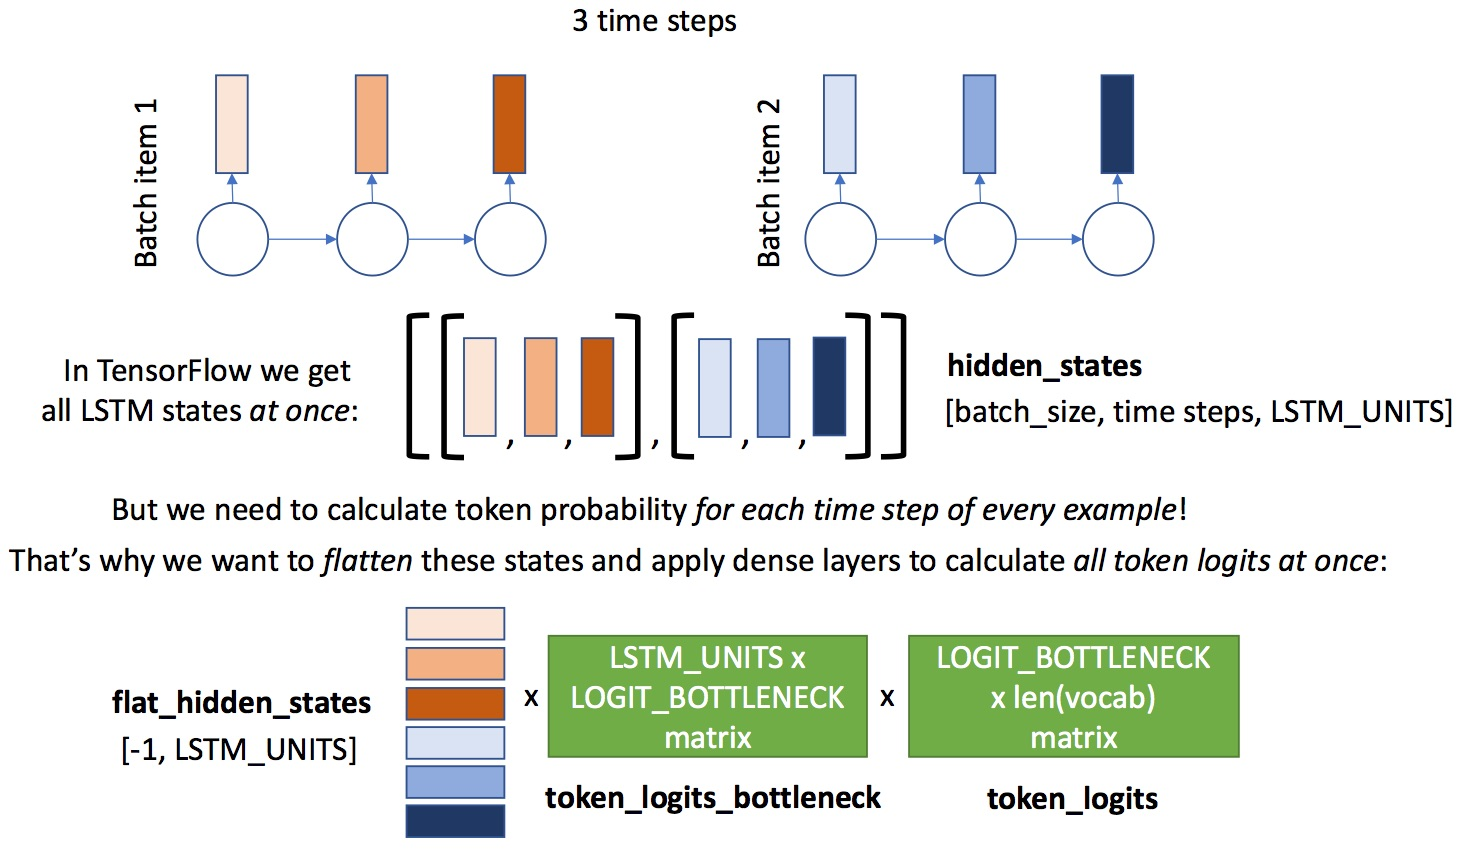

In [84]:
class decoder:
    # Decoder architecture description-->
    
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # using bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # using bottleneck to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # Condition lstm cell on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embeding all tokens except for the last for lstm input,
    # L.Embedding is callable,
    # using `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])
    
    # during training ground truth tokens `word_embeds` are used as context for next token prediction.
    # So all the inputs for lstm are known and can obtain 
    # all hidden states with single tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # calculating token logits for all the hidden states
    
    # reshaping `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # calculating logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # flattening the ground truth token ids.
    # predicting next tokens for each time step - using `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1,])

    # indices of real tokens (not padding) in `flat_ground_truth` are required.
    # the loss due padded output tokens are not propagated to subsequent layers
    # `flat_loss_mask` is filled with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    
    # flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)
    flat_loss_mask = tf.cast(tf.not_equal(flat_ground_truth, pad_idx) ,dtype=tf.float32)

    # computing cross-entropy between `flat_ground_truth` and `flat_token_logits` - which is predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # computing average `xent` over tokens with nonzero `flat_loss_mask`.
    # Not taking into account misclassification of PAD tokens, as that does not contain relevant information
    # PAD tokens are ONLY for batching purposes!
    
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))
    #loss = tf.reduce_sum(tf.multiply(xent,flat_loss_mask)) / tf.reduce_sum(flat_loss_mask)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# defining optimizer to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# to reset default graph and define it in the same way in order to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

## Training Iterations for building the model
Evaluating train and validation metrics through training and logging them. 
Ideally, the loss should decrease with every iteration of the loop.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generating batch via random sampling of images and captions for them,
# using `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generating a random batch of size `batch_size`.
    Taking random images and choose one random caption for each image.
    using `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    batch = np.random.choice(len(images_embeddings), batch_size, replace=False)
    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[batch]]
    
    batch_image_embeddings = images_embeddings[batch]
    
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
        
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # number of batches used for validation after each epoch

In [ ]:
# loading trained weights here
# uncomment the next line to load weights
#saver.restore(s, get_checkpoint_path(epoch=4))
saver.restore(s, '/content/weights')

Keeping an eye on the training and validation loss - the losses should ideally be monotonically decreasing.

In [89]:
# training loop
MAX_LEN = 20  # truncate long captions to speed up training - check the captions in the training data for appropriate length.

# make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # saving weights after finishing each epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.286516
Epoch: 0, train loss: 4.28651642370224, val loss: 3.7181424427032472
**************************************************
Training loss: 3.377820
Epoch: 1, train loss: 3.3778202052116395, val loss: 3.1486745381355288
**************************************************
Training loss: 3.032517
Epoch: 2, train loss: 3.032517340183258, val loss: 2.9714315223693846
**************************************************
Training loss: 2.862450
Epoch: 3, train loss: 2.862449791431427, val loss: 2.860742847919464
**************************************************
Training loss: 2.769610
Epoch: 4, train loss: 2.769609961271286, val loss: 2.801822805404663
**************************************************
Training loss: 2.703709
Epoch: 5, train loss: 2.7037092430591585, val loss: 2.7378395557403565
**************************************************
Training loss: 2.644635
Epoch: 6, train loss: 2.6446347007751463, val loss: 2.70

In [92]:
# check if model has learnt necessary features, output of accuracy of next word prediction should be around 0.5

from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.5595477
Accuracy: 0.4868766404199475
Example 0
Predicted: a man holding a from a in a #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man pouring wine from #UNK# for patrons #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man is to of cart to in #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man tries out a bicycle powered blender #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predi

In [93]:
# saving last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/weights'

# Model Inference

## Implementation of model inference

Here, a construction of the computation graph for the final model is discussed.

Model execution procedure is as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [ ]:
import keras.backend as K
K.manual_variable_initialization(False)

In [94]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    #saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    saver.restore(s, '/content/weights')

    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # obtainging image embeddings
    img_embeds = encoder(input_images)

    # initializing lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # applying lstm cell and to get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # computing logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # computing probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/weights


In [95]:
# Observing probability distributions
# for high temperature - more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # conditioning lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # For current caption here --
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # applying temperature for probability distribbution
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a young boy holding a baseball bat in his hand


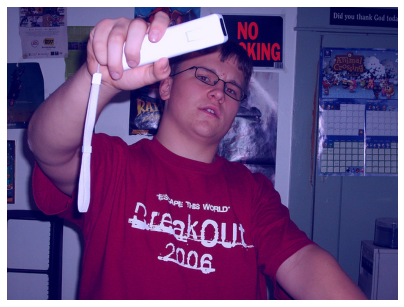

a sheep standing next to a fence in a field


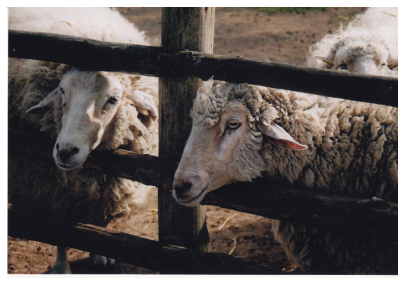

a street sign on a pole next to a street sign


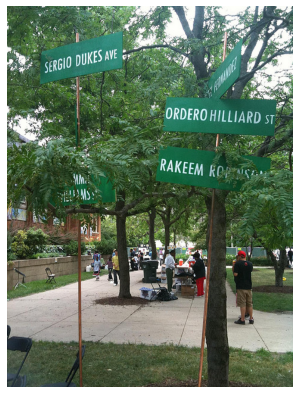

a bowl of fruit and fruit on a table


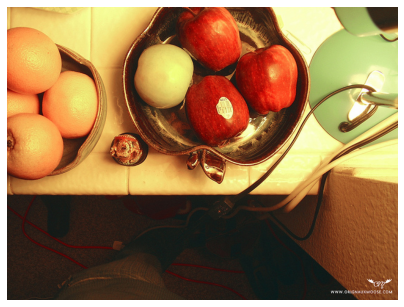

a group of people standing in a field with a frisbee


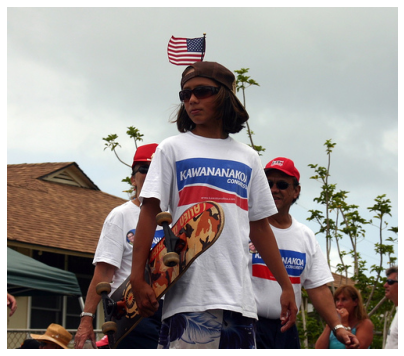

a kitchen with a stove and a window in a kitchen


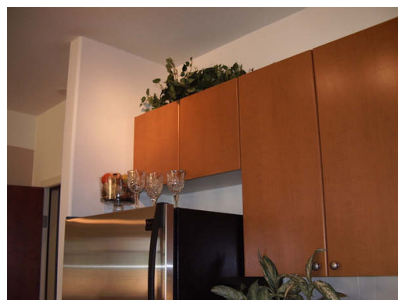

a double decker bus driving down a street


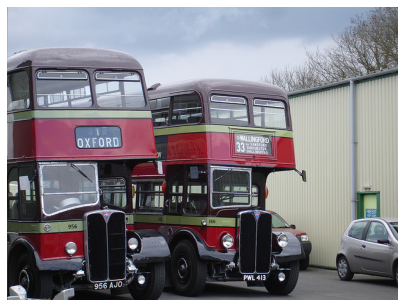

a woman sitting on a couch with a laptop computer


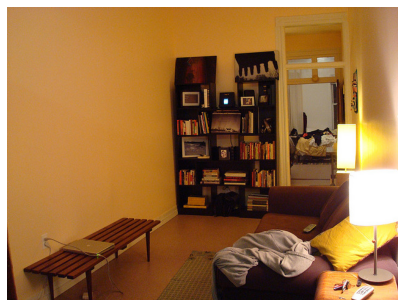

a bicycle parked next to a building with a dog on the back


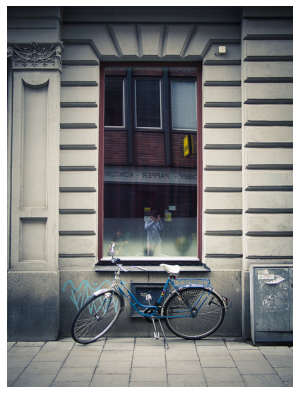

a tennis player is hitting a ball with a racket


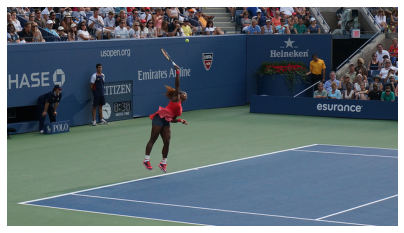

In [98]:
# sampling more images from validation dataset
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

# Assessing Model Performance

In [ ]:
# Checking validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

Checking the performance of the model by running it on different images in the training/validation dataset.

Model is executed as follows:

- Running the model on images from validation set:

```python
show_valid_example(val_img_fns, example_idx=...)
```

- Executing model on images from the Internet or on any image:

```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```


# Prediction on images from the Validation dataset

a street sign on a pole next to a street sign


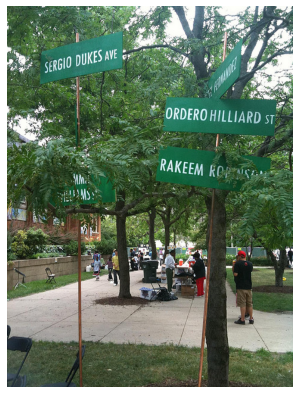

In [100]:
# predictions from the validation set
show_valid_example(val_img_fns, example_idx= 10 )

a cow standing in a field with a tree in the background


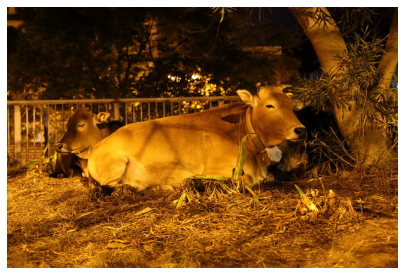

In [101]:
show_valid_example(val_img_fns, example_idx= 99 )

a herd of sheep grazing in a field of grass


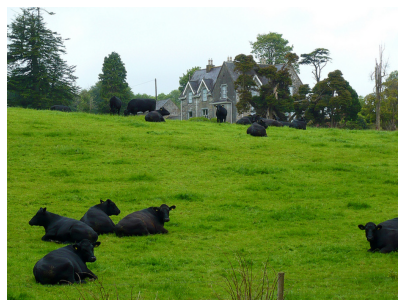

In [103]:
show_valid_example(val_img_fns, example_idx= 150 )

a man walking down a street holding a skateboard


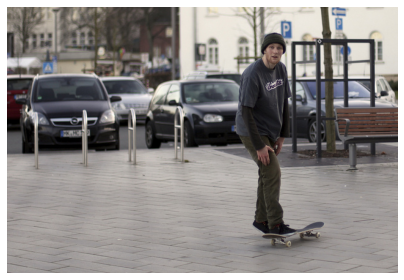

In [104]:
show_valid_example(val_img_fns, example_idx= 200 )

a man holding a cell phone in his hand


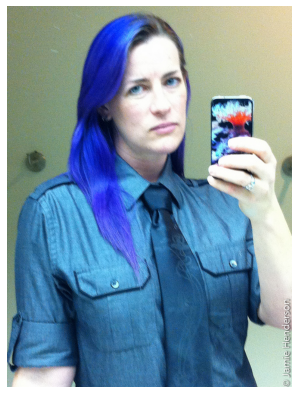

In [105]:
show_valid_example(val_img_fns, example_idx= 250 )

a man in a red shirt is playing frisbee


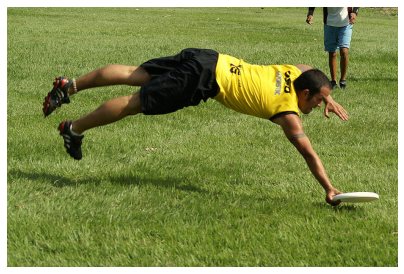

In [106]:
show_valid_example(val_img_fns, example_idx= 288 )

a bed with a bed and a bed


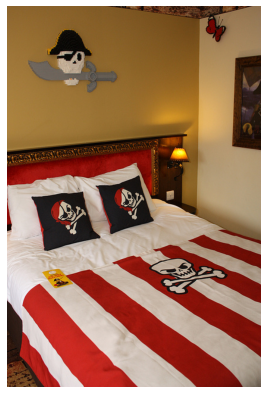

In [107]:
show_valid_example(val_img_fns, example_idx= 289 )

a herd of zebras standing in a field with a mountain in the background


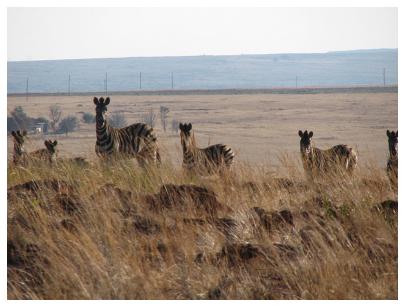

In [108]:
show_valid_example(val_img_fns, example_idx= 300 )

a man in a white shirt standing next to a mirror


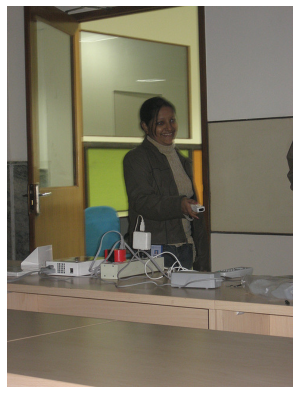

In [109]:
show_valid_example(val_img_fns, example_idx= 240 )

a microwave oven sitting next to a microwave on a counter


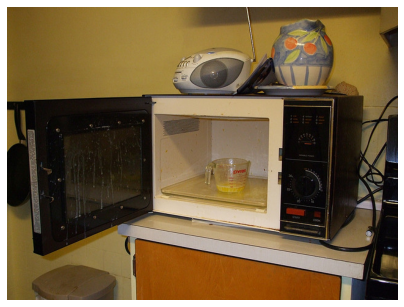

In [112]:
show_valid_example(val_img_fns, example_idx= 96 )

a dog sitting on a bench in a field


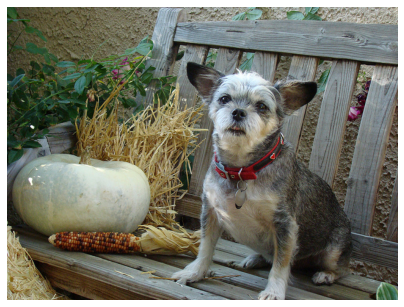

In [114]:
show_valid_example(val_img_fns, example_idx= 69 )

# Prediction on Random Images from the Internet

To assess the performance of the trained model, images downloaded from the internet have been used. Some of the results of the generated captions are interesting! They are as follows.

a woman in a kitchen with a plate of food


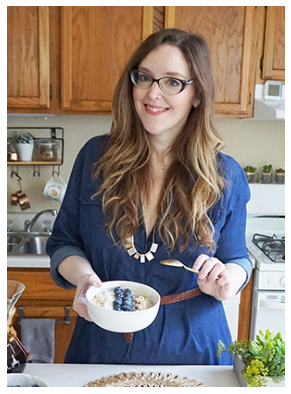

In [115]:
# images and their captions downloaded from the internet
apply_model_to_image_raw_bytes(open("/content/images/DSC0476422.jpg", "rb").read())

a bowl of soup with a spoon and a spoon


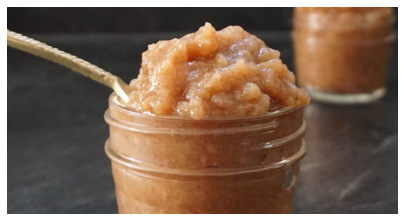

In [116]:
apply_model_to_image_raw_bytes(open("/content/images/instant-pot-apple-sauce-lead.jpg", "rb").read())

a plate of food with a variety of vegetables


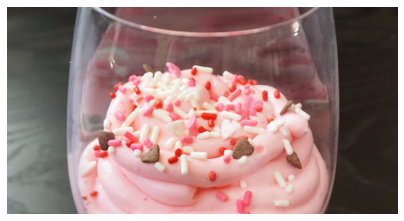

In [117]:
apply_model_to_image_raw_bytes(open("/content/images/keto-cheescake-mousse-lead.jpg", "rb").read())

a store with a lot of different types of umbrellas


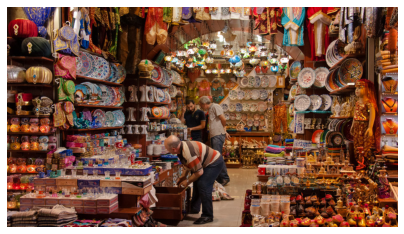

In [119]:
apply_model_to_image_raw_bytes(open("/content/images/turkey-credit-Joshua-Tagicakibau.jpg", "rb").read())

a group of people sitting around a table with a cake


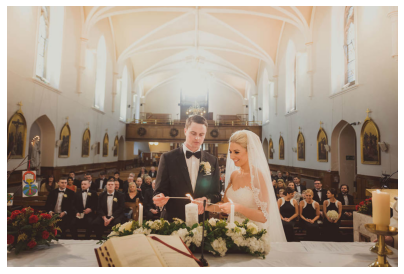

In [120]:
apply_model_to_image_raw_bytes(open("/content/images/image-asset.jpeg", "rb").read())

a group of young men playing soccer on a field


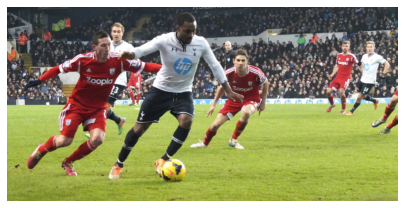

In [122]:
apply_model_to_image_raw_bytes(open("/content/images/photo-3102.jpg", "rb").read())

a man in a red shirt is playing a game of soccer


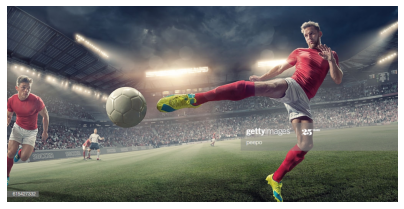

In [123]:
apply_model_to_image_raw_bytes(open("/content/images/gettyimages-615427332-1024x1024.jpg", "rb").read())

# Conclusion

The Model has been successfully trained and captions describing test images have been generated. Further, captions of random images from the internet have been created to validate the working of the trained model. The captions can be improved by training the model for greater number of iterations in order to increase the accuracy.